# Epistemic uncertainties in flood hazard mapping
Author: Mariano Balbi

This notebook develops the main numerical models that appear in the manuscript "The cost of imperfect knowledge: how epistemic uncertainties influence flood hazard assessments", and most of the plots that can be found there.

This notebook uses the following Python packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as st
import pandas as pd
import seaborn as sns
import osgeo.gdal as gdal
import pickle

from potanalysis import clust, autocorr, MRL, TC, diagnostic_plots, ecdf
from potanalysis import bayesian_diagnostic_plots
from mh_posterior import mh_paths_sampler, paths_diagnostics
from flood_simulator import Lisflood, read_flood_results

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.rcParams.update({'font.size': 8, 'lines.linewidth':0.8, 'axes.linewidth':0.5,
                     'xtick.major.width':0.5, 'ytick.major.width':0.5});


Bad key savefig.frameon in file c:\Users\maria\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file c:\Users\maria\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file c:\Users\maria\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log fi

---
## 1. Recurrence model

A recurrence model is built from a Peaks-Over-Threshold (POT) methodology to obtain the mean recurrence rate of events and the probability distribution of the magnitudes of each event (GPD).

### 1.1 Input data

Input data for the recurrence model is a Historical time series of daily river discharges from Thames river at Buscot. This data can be found in the repository and was obtained from the UK National River Archive.

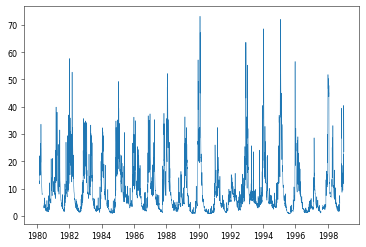

In [3]:
# Read discharge data
filename = 'data\\Buscot-daily_discharge.csv'
df = pd.read_csv( filename, usecols=[0,1], skiprows=19, parse_dates=[0] )

# Add 'time' and 'obs' index columns
df['obs'] = df['discharge']
df['time'] = np.arange( 0, len(df), 1 )

# Fill NaN values with interpolation
df0 = df.interpolate('linear')

# Plot time series
fig, ax = plt.subplots()
ax.plot( df['date'], df['discharge'], linewidth=0.5 );

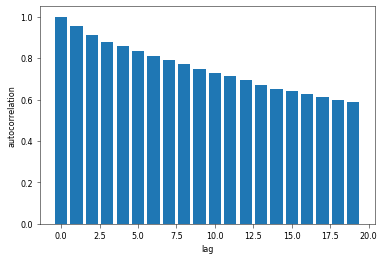

In [4]:
# Autocorrelation of the series
acf, ax = autocorr( df['discharge'], plot=True );

### 1.2 Peaks-over-threshold (POT) model

POT model for analysis of time series extremes jointly characterizes the occurrence in time of events, via a Poisson process, and the distribution of the magnitude of events above a certain threshold $u$.
$$
F_{T} \left( x \right) = \exp \left\{ -\lambda_0 T P \left( X \leq x \right) \right\}
$$

Where the distribution of amplitudes above the threshold $u$ is given by the Generalized Pareto Distribution (GPD).

$$
P \left( X - u \leq x| \xi, \sigma \right) =
    \begin{cases}
       1- \left( 1+ \frac{\xi}{\sigma}y\right)^{-1/\xi},& \text{if $\xi \neq 0$}\\
       1 - \exp \left( - \frac{y}{\sigma} \right),& \text{if $\xi = 0$}
    \end{cases}
$$

The parameters of the GPD distribution $\xi$ and $\sigma$ are obtained from the clustered data, for a given threshold $u$. The threshold is defined as the minimum value by which the cluster maxima above that level occur at approximately independent, exponentially distributed, interarrival times. 

#### 1.2.1 Clustering of data

The exceedances of the daily discharges time-series over a given threshold $u$ is

c:\Users\Admin\OneDrive - fi.uba.ar\PhD\Projects\Probabilistic flood hazard\models\frequency\potanalysis.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfu['dt'] = np.append( 0, np.diff( dfu['time'] ) )


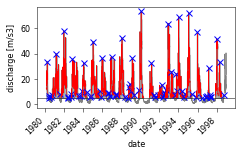

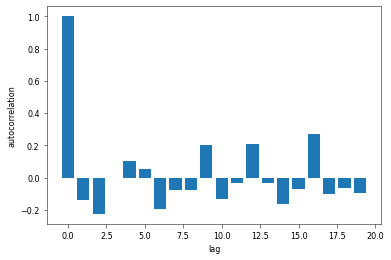

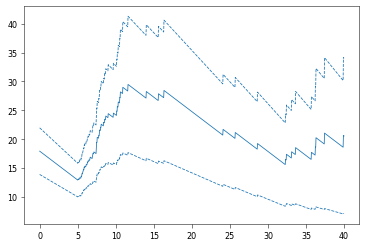

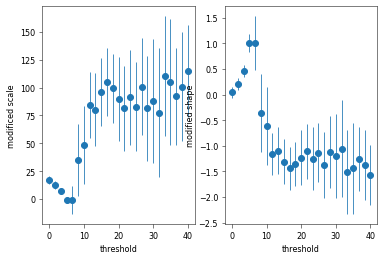

In [7]:
# Declustering of series
df_cl, ax = clust( df, u=5, time_cond=7, clust_max=True, plot=True)
acf, ax = autocorr( df_cl['obs'], plot=True )

# Mean Residual Life Plot
_, mrl, ax = MRL( df_cl['obs'], lims=(0,40), plot=True )

# Modified scale and shape plots
scale_mod, shape, ax = TC( df_cl['obs'], N=25, lims=(0,40), plot=True );

With the selected threshold $u$ the clustering is performed again and cluster maxima are extracted for parameters inference. The autocorrelation of the cluster maxima is evaluated to check independence of the series.

c:\Users\maria\OneDrive - fi.uba.ar\PhD\Projects\Probabilistic flood hazard\paper\repository\potanalysis.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfu['dt'] = np.append( 0, np.diff( dfu['time'] ) )


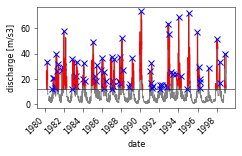

In [5]:
# Fit GPD to exceedance points with selected threshold u
u = 12
df_cl, ax_clust = clust( df, u=u, time_cond=7, clust_max=True, plot=True)
fig = ax_clust.figure
# Observations above the selected threshold
qu = df_cl['obs'][ df_cl['obs']>u ] - u;

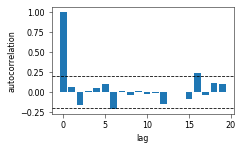

In [6]:
acf, ax = autocorr( qu, plot=True )
ax.figure.set_size_inches(8.3/2.54, 5/2.54)
ax.axhline( y=0.2, color='k', linestyle='--')
ax.axhline( y=-0.2, color='k', linestyle='--')
fig.tight_layout()

#### 1.2.2 Fitting the mean recurrence of events

The posterior distribution for the mean interarrival time $\lambda$ is analytically obtained by assuming a non-informative Jeffrey's prior $Gamma \left( 1/2,0 \right)$. The posterior is, then, also Gamma-distributed as,

$$
\lambda | \mathbf{t} \sim Gamma \left( n+\frac{1}{2}, T + \frac{1}{2} \right)
$$

And the predictive posterior of inter-arrival times,
$$
T_i - T_{i-1} \sim Lomax( n+\frac{1}{2}, T+\frac{1}{2})
$$

Where $T$ is the total time of the series and $n$ the total number of events

In [7]:
# Mean recurrence interval
ti = np.diff( df_cl.time )
n = len(qu) # Events occurred
T = len(df)/365 # Total time in years
m_mean = (n+1/2)/T
# Posterior of mean rate
m_dist = st.gamma( n+1/2, loc=0, scale=1/(T+1/2) )
# Predictive posterior of interarrival times
T_pred = st.lomax( n+1/2, loc=0, scale=T+1/2 );

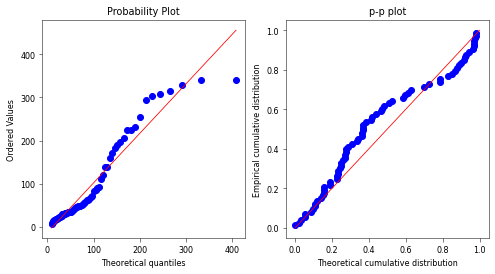

In [8]:
# Check exponential distribution of interarrival times
distr = st.expon
ti_params = distr.fit( ti )
_ = diagnostic_plots( ti, distr, ti_params );

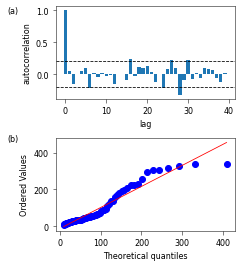

In [9]:
fig, ax = plt.subplots( figsize=( 8.5/2.54, 10/2.54 ), nrows=2 )

# Autocorrelation plot
ax[0].text(0.02, 0.90, '(a)', fontsize=8, transform=plt.gcf().transFigure)
acf = [qu.autocorr(lag=i) for i in range(0,40)]
ax[0].bar( range(0,40), acf )
ax[0].axhline( y=0.2, color='k', linestyle='--' )
ax[0].axhline( y=-0.2, color='k', linestyle='--' )
ax[0].set_xlabel( 'lag' )
ax[0].set_ylabel( 'autocorrelation' )
        
# Probability plot
ax[1].text(0.02, 0.45, '(b)', fontsize=8, transform=plt.gcf().transFigure)
res = st.probplot( ti, dist=distr, sparams=ti_params, plot=ax[1] )
ax[1].set_title('')

fig.tight_layout()

#### 1.2.3 Fitting the magnitude of the events

The exceedances above threshold $u$ are modelled by a GPD, following the standard extreme value theory. The prior distributions of the parameters are Gaussian, centered at the MLE obtained by classical optimization techniques, and with a large variance to represent non-informativenesss.

The data likelihood is given by,
$$
\mathbf{y} | \xi, \sigma = \prod_{i}  \frac{1}{\sigma} \left( 1 + \xi \frac{y_i-u}{\sigma}\right)^{-\frac{1}{\xi} - 1}
$$

And the priors for each parameter,
$$
\begin{aligned}
\xi &\sim \mathcal{N} \left( \hat{\xi}, 10\cdot\hat{\xi}\right)\\
\sigma &\sim \mathcal{N} \left( \hat{\sigma}, 10 \cdot \hat{\sigma} \right)
\end{aligned}
$$

The following lines implement a MCMC simulation to draw samples from the posterior distribution of the GPD parameters $\xi$ and $\sigma$. It is an implementation developed by myself, and can be found in the mh_posterior.py script.

Starting path 1 of 4


c:\Users\maria\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Starting path 2 of 4
Starting path 3 of 4
Starting path 4 of 4


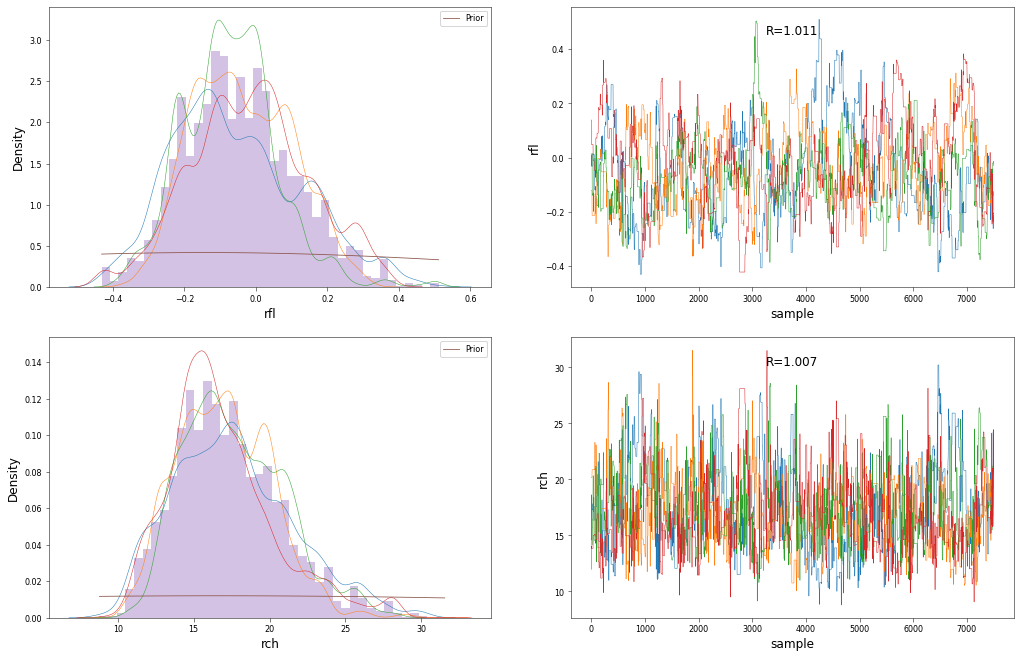

In [10]:
# MLE estimates
t_mle = st.genpareto.fit( qu, floc=0 )
# Priors (Jeffrey's prior from)
logPrior = lambda t: -np.log(t[1]) - np.log(1+t[0]) - 1/2*np.log(1+2*t[0])
t1_prior = st.norm( loc=3*t_mle[0], scale=np.abs(t_mle[0]*20) )
t2_prior = st.norm( loc=t_mle[2], scale=np.abs(t_mle[2]*2) )
logpriors = [t1_prior, t2_prior]
# Log-likelihood
logLikelihood = lambda t: sum( st.genpareto.logpdf(qu, t[0], loc=0, scale=t[1]) )
# Posterior
target_logpdf = lambda t: logLikelihood( t ) + logPrior( t )
# MCMC
Npaths = 4; Nsim = 15000; burnin = int(Nsim/2+1)
x0 = np.random.uniform( [-0.2,14], [0.2,20], [Npaths+1,2] )
sigmas = np.array([t_mle[0]*1.5, t_mle[2]*1.5])
cov = sigmas**2*np.eye(len(sigmas))
Xbin, Xstack, acceptance, _ = mh_paths_sampler(target_logpdf, Npaths, 
                                               Nsim, x0, cov,
                                               burnin=burnin, thin=1,
                                               sampler='adaptive', tune=1000,
                                               tune_intvl=4000,
                                               proposal=None)
# MCMC convergence diagnostics
R, var_j, rhot, neff = paths_diagnostics( Xbin, True, *logpriors )

We check the fit of the posterior predictions of discharge, versus the GPD distribution

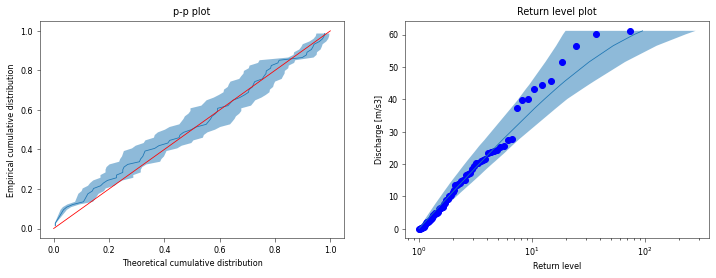

In [11]:
# Fit diagnostics
qFi, qTri, fig = bayesian_diagnostic_plots( qu, st.genpareto, Xstack, conf=0.9 );

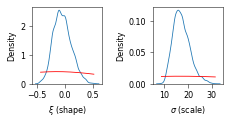

In [12]:
# Plot for paper
fig, ax = plt.subplots( figsize=(8.5/2.54,4.5/2.54), ncols=2 )
sns.kdeplot( Xstack[:,0], fill=False, ax=ax[0], label='posterior', bw_adjust=1.5 )
shape_x = np.linspace( Xstack[:,0].min(), Xstack[:,0].max(), 1000 )
ax[0].plot( shape_x, t1_prior.pdf( shape_x ), color='r', label='prior' )
ax[0].set_xlabel(r'$\xi$ (shape)')
sns.kdeplot( Xstack[:,1], fill=False, ax=ax[1], bw_adjust=1.5 )
scale_x = np.linspace( Xstack[:,1].min(), Xstack[:,1].max(), 1000 )
ax[1].plot( scale_x, t2_prior.pdf( scale_x ), color='r' )
ax[1].set_xlabel(r'$\sigma$ (scale)')
# ax[0].legend()
fig.tight_layout()

### 1.3 Posterior predictions of discharges

This code computes posterior predictions of new discharge observations (predictive posterior predictions) using the samples from the posterior parameters obtained before.

In [13]:
# Number of simulations
N = 10000

# Simulate interarrival times
mi = m_dist.rvs( size=N )

# Simulate new observations of discharges (posterior predictive)
indices = np.random.choice( Xstack.shape[0], size=N )
x_plot = np.arange(0.1,150,0.1)
Tr_plot = np.arange(0.2,500,0.1)
Fi = np.zeros( [len(x_plot), N] )
x_Tri = np.zeros( [len(Tr_plot), N] )
rQ = np.zeros( N )
for i in range( N ):
    t = Xstack[indices[i],:]
    Fi[:,i] = st.genpareto.cdf( x_plot, t[0], loc=0, scale=t[1] )

# Return levels for discharges

# Empirical from observations
Fi_emp = ecdf( qu + u )[1]
pannual_emp = (1 - Fi_emp) * m_mean

# MAP
pannual_map = (1 - st.genpareto.cdf( x_plot, *t_mle )) * m_mean

# Posterior curves and predictive posterior estimate
pannuali = (1-Fi)*mi
qi = (1 - 0.9)/2; qs = (1 + 0.9)/2
pannual_ci = np.quantile( pannuali, [qi,qs], axis=1) 
pannual_mean = np.mean( pannuali, axis=1 )

Here we plot the return levels of discharges comparing the predictive posterior estimate with the MAP estimate of the GPD distribution.

c:\Users\maria\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


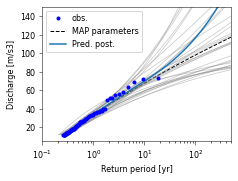

In [15]:
# Plot
fig, ax = plt.subplots( figsize=(8.5/2.54,6.5/2.54) )

# X model plot

# Observations
ax.plot( 1/pannual_emp, np.sort(qu)+u, 'bo', markersize=3, label='obs.', zorder=10 )

# MLE
ax.plot( 1/pannual_map, x_plot+u, label='MAP parameters', linewidth=1,
            color='k', linestyle='--' )

# Posterior curves
ax.plot( 1/pannuali[:,:30], x_plot + u, color='gray', alpha=.4  )

# Predictive posterior curve
ax.plot( 1/pannual_mean, x_plot+u, label='Pred. post.', linewidth=1.5 )

ax.set_xlabel( 'Return period [yr]' )
ax.set_ylabel( 'Discharge [m/s3]' )
ax.set_xlim([0.1,500])
ax.set_ylim([5,150])
ax.set_xscale('log')
ax.legend( loc='best', fontsize=8 )
fig.tight_layout();

## 2. Source-to-site model (inundation model)

The computational simulator for the inundation used here is Lisflood-fp, a hydrodynamical finite-differences model. The parameters used for calibration are the channel and floodplain roughness. They were calibrated following the GLUE procedure and using a single binary flood extent observation.

### 2.1 Input data

Input data used for the model can be found in the repository, and are listed here:
- Flood extent observation: Provided by Jim W. Hall from Oxford University
- Digital Elevation Map (DEM): UK Environment Agency maps and surveys
- Channel mask: Created specifically for this

In [51]:
# Training Data (flood extent observation)
bounds = [0,48,0,76]
src = gdal.Open( 'data/BuscotFlood92.tiff' )
z = src.GetRasterBand(1).ReadAsArray()
src = None
z = z[bounds[0]:bounds[1],bounds[2]:bounds[3]]

# DEM
dem = 'Buscot.dem.asc'
src = gdal.Open( dem )
dem = src.GetRasterBand(1).ReadAsArray()
src = None

# Channel mask
src = gdal.Open( 'Buscot.bed.asc' )
channel = src.GetRasterBand(1).ReadAsArray()
channel[channel<=0] = np.nan
channel[channel>0] = 1
src = None

And here is a plot of the flood extent observation on top of the DEM

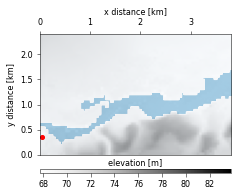

In [52]:
fig, ax = plt.subplots( figsize=(8.5/2.54,7/2.54) )
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
o1 = ax.imshow( dem, cmap='Greys', extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05] )
o2 = ax.imshow( z, cmap='Blues', extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05],
                vmin=0.9, vmax=1.1, alpha=0.6 )
o3 = ax.imshow( channel, cmap='Blues', extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05],
                vmin=0.99, vmax=1.0 )
o4 = ax.plot( 0.05, 0.35, marker='o', markersize=4, color='r', label='input' )

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes( "bottom", size="3%", pad=0.2 )
bar = plt.colorbar( o1, cax=cax, ticks=np.arange(68,86,2), orientation='horizontal' )
bar.ax.set_xlabel('elevation [m]', rotation=0, loc='center' )
bar.ax.xaxis.set_label_position('top') 

# Settings
ax.set_xlabel( 'x distance [km]' )
ax.set_ylabel( 'y distance [km]' )
# ax.legend( loc='best' )
fig.tight_layout()

### 2.2 GLUE calibration

The two roughness parameters for the model are calibrated following the GLUE methodology. Simulations of the flood simulator are performed for different combinations of the parameters, and for a fixed input discharge of 73m/s

#### 2.2.1 Simulations over a grid

The flood simulator was ran for a grid of roughness parameters (both for channel and floodplain) varying in the range (0.01,0.15) with a 0.01 step. The simulations were ran in a different script (lisflood_grid_simulations.py) and the resultant flood maps were saved in a separate folder.

In [19]:
folder = 'data\\Grid_060622_qvar146_U2'
S_glue, A, B, C, r_ch_grid, r_fp_grid = read_flood_results( folder, read_maps=False )

#### 2.2.2 F-scores and posterior distribution

Each map has a computed F-score. F-scores are then filtered by a minimum threshold, and standardized so they are probabilities.

In [53]:
F = (A-B)/(A+B+C) # F-score
Fs = ( F - F.min() )/( F.max() - F.min() )
w0 = Fs/Fs.sum()

# Filter by minimum F-score
filter = F > 0.5
Fs_filtered = Fs[ filter ]
r_ch_filtered = r_ch_grid[ filter ]
r_fp_filtered = r_fp_grid[ filter ]

# Weights (posterior probability) for each parameter value
w_filtered = Fs_filtered/Fs_filtered.sum()
w = np.zeros( F.shape )
w[ filter ] = w_filtered

# Mean posterior parameters
r_glue_mean = ( np.average(r_ch_grid,weights=w), np.average(r_fp_grid,weights=w) )

# MAP parameters
max_ix = np.where( F==F.max() )[0][0]
r_glue_max = ( r_ch_grid[max_ix], r_fp_grid[max_ix] )

...this is the resultant probability distribution for the parameters

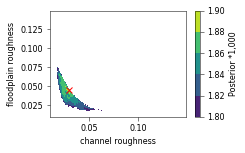

In [54]:
# Plot the results
nrch = len(np.unique(r_ch_grid))
nrfp = len(np.unique(r_fp_grid))
X = r_ch_grid.reshape( nrch, nrfp )
Y = r_fp_grid.reshape( nrch, nrfp )
Z = w.reshape( nrch, nrfp )

# Plot
fig, ax = plt.subplots( figsize=(8.5/2.54,5.5/2.54) )
o1 = ax.contourf( X, Y, Z*1000, levels=[1.8,1.82,1.84,1.86,1.88,1.9] )
bar = plt.colorbar( o1 )
bar.ax.set_ylabel('Posterior *1,000', rotation=90)
ax.plot( r_glue_max[0], r_glue_max[1], 'rx')

# Settings
ax.set_xlabel( 'channel roughness' )
ax.set_ylabel( 'floodplain roughness' )
fig.tight_layout()

## 3. Hazard assessment

The hazard is computed by simulating $N$ discharge events, and running the inundation simulator for each. Parameters of the GPD distribution for discharges are sampled from their posterior distribution. Roughness parameters for the inundation simulator are sampled from their posterior distribution.

The $N$ flood maps, and the simulated parameters, were ran in a separate script (time_history_simulation.py) and the results saved in a pickle file (only read in python). The pickle file contains more than 100,000 flood maps and weights around 4Gb.

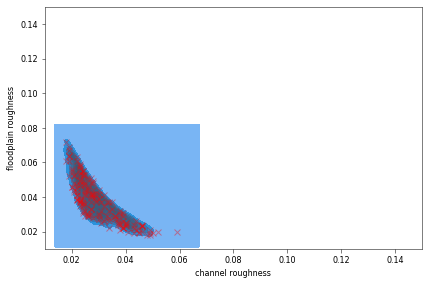

In [41]:
# Load variables
sim_name = '\\110423_T10000N1_GLUE'
with open( sim_name+'.pkl', 'rb') as file:
    parameters = pickle.load( file )
    S_sim = pickle.load( file ) # Posterior distribution
    S_sim_1 = pickle.load( file ) # Predictive posterior discharges + MAP flood simulator
    S_sim_2= pickle.load( file ) # Best-fit GPD discharges + posterior flood simulator
    S_sim_3 = pickle.load( file ) # Best-fit GPD discharges + MAP flood simulator

# Plot the sampled roughness parameters as a check
fig, ax = plt.subplots()
# 2D density
sns.kdeplot( x=parameters['rch'], y=parameters['rfp'], fill=True, thresh=0 )
# Samples
ax.plot( parameters['rch'][:150], parameters['rfp'][:150], 'rx', alpha=.4)

ax.set_xlim([0.01,0.15])
ax.set_ylim([0.01,0.15])
ax.set_xlabel( 'channel roughness' )
ax.set_ylabel( 'floodplain roughness' )
fig.tight_layout()

The water depths and return periods used for plotting

In [55]:
# range of values for plotting
z_plot = np.arange( 0.01, 2, 0.01 ) # Z levels
Tr_plot = np.arange(0.2,500,0.1) # Tr values

### 3.1 Best-fit hazard (classical approach)

This hazard curve is obtained from fixed MLE parameters for the GPD distribution, mean rate of occurrence of events, and the MAP roughness parameters.

In [43]:
# List of return periods to compute flood maps
trs = np.array([1.5,2,2.5,3,5,10,15,20,30,40,50,100,150,200,250,300,350,400,500,1000])

S_map_trs = np.zeros( (trs.size, z.shape[0], z.shape[1]) )
q_trs = np.zeros( trs.size )
for i in range( trs.size ):
    # Discharge for each return period
    q_trs[i] = st.genpareto.ppf( 1-1/trs[i]/m_mean, *t_mle ) + u
    # Flood map for each discharge
    S_map_aux = Lisflood( 'array', q_trs[i], 68.43, r_glue_max, output=None )
    # Store and trim to bounds
    S_map_trs[i] = S_map_aux[ bounds[0]:(bounds[1]+1), bounds[2]:(bounds[3]+1) ]

### 3.2 Predictive posterior hazard

Obtain empirical cumulative distributions of water depths  at aspecific point in space for the $N$ simulations series

In [56]:
N0 = parameters['N0'] # Total number of events
T0 = parameters['T0'] # Total number of time

# Observation point
px = 21 + 9
py = 26

# 1. Predictive posterior discharges + posterior flood simulator
# Annual probability of exceedance
rs_sort, Femp = ecdf( S_sim[:,px,py] )
# Interpolation for plotting
lZ_1 = N0/T0 * np.interp( z_plot, rs_sort, 1-Femp )

# 2. Predictive posterior discharges + MAP flood simulator
# Annual probability of exceedance
rs_sort, Femp = ecdf( S_sim_1[:,px,py] )
# Interpolation for plotting
lZ_2 = N0/T0 * np.interp( z_plot, rs_sort, 1-Femp )

# 3. Best-fit GPD discharges + posterior flood simulator
# Annual probability of exceedance
rs_sort, Femp = ecdf( S_sim_2[:,px,py] )
# Interpolation for plotting
lZ_3 = N0/T0 * np.interp( z_plot, rs_sort, 1-Femp )

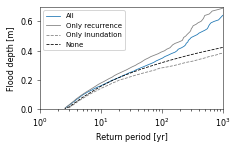

In [57]:
# Exceedance curves
fig, ax = plt.subplots( figsize=(8.5/2.54,5.5/2.54) )
ax.plot( 1/lZ_1, z_plot, label='All' )
ax.plot( 1/lZ_2, z_plot, label='Only recurrence', color='gray' )
ax.plot( 1/lZ_3, z_plot, label='Only inundation', linestyle='--', color='gray' )

ax.plot( trs, S_map_trs[:,px,py], label='None', linestyle='--', color='k' )
ax.set_xlabel( 'Return period [yr]' )
ax.set_ylabel( 'Flood depth [m]' )
ax.set_xlim([1,1000])
ax.set_ylim([0,0.7])
ax.set_xscale('log')
ax.legend( loc='upper left', fontsize=7 )
fig.tight_layout()

### 3.3 Hazard mapping

Develop flood hazard maps by computing the predictive posterior flood depths at every point

In [58]:
# Target return periods
Tmaps = [100,250,500]

z_map = np.zeros( [z.shape[0],z.shape[1],len(Tmaps)] )
S_map = np.zeros( [z.shape[0],z.shape[1],len(Tmaps)] )
for k in range(len(Tmaps)):
    # Map for some return period
    Tmap = Tmaps[k]
    for i in range( S_sim.shape[1] ):
        for j in range( S_sim.shape[2] ):
            # Annual probability of exceedance
            rs_sort, Femp = ecdf( S_sim[:,i,j] )
            # Interpolation
            G_aux = N0/T0 * np.interp( z_plot, rs_sort, 1-Femp )
            # Water depth for given return period
            z_map[i,j,k] = np.interp( Tmap, 1/G_aux, z_plot  ) - z_plot.min()

    # Classical approach map for given return period
    q_Tmap = st.genpareto.ppf( 1-1/Tmap/(N0/T0), *t_mle ) + u
    S_map_aux = Lisflood( 'array', q_Tmap, 68.43, r_glue_max, output=None )
    S_map[:,:,k] = S_map_aux[bounds[0]:bounds[1],bounds[2]:bounds[3]]

Plot the flood hazard map for any of the specified return periods

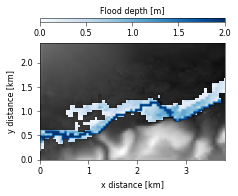

In [59]:
i=0 # return period index

# Plot
fig, ax = plt.subplots( figsize=(8.5/2.54,7/2.54) )
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top') 
o1 = ax.imshow( dem[bounds[0]:bounds[1],bounds[2]:bounds[3]], cmap=cm.gray,
                extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05])

# Make 0 water-depth as transparent
masked_data = np.ma.masked_where( z_map[:,:,i] == 0, z_map[:,:,i] )
o2 = ax.imshow( masked_data, extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05], 
                vmin=0, vmax=2, cmap='Blues' )

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes( "top", size="3%", pad=0.3 )
bar = plt.colorbar( o2, cax=cax, orientation='horizontal' )
bar.ax.set_xlabel('Flood depth [m]', rotation=0, loc='center' )
bar.ax.xaxis.set_label_position('top') 
ax.set_xlabel( 'x distance [km]' )
ax.set_ylabel( 'y distance [km]' )
fig.tight_layout()

Plot the difference map between the predictive posterior map and the classical map

c:\Users\maria\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:29: UserWarning: The following kwargs were not used by contour: 'linewidth'


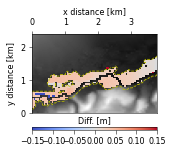

In [60]:
import matplotlib.colors as colors
# Map difference for given return period
i = 0 
Sdiff = z_map[:,:,i] - S_map[:,:,i]

# Plot
fig, ax = plt.subplots( figsize=(8.5/2.54,5.5/2.54) )
# ax.xaxis.set_label_position('top') 
masked_data = np.ma.masked_where( Sdiff == 0, Sdiff )
masked_data = np.ma.masked_where( channel[bounds[0]:bounds[1],bounds[2]:bounds[3]] >= 0, masked_data )
dem_img = ax.imshow( dem[bounds[0]:bounds[1],bounds[2]:bounds[3]], cmap=cm.gray,
                     extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05])

cmap = cm.Blues  # Can be any colormap that you want after the cm
divnorm = colors.TwoSlopeNorm(vcenter=0., vmin=-0.15, vmax=0.15)
image = ax.imshow( masked_data[:,:], cmap='coolwarm', norm=divnorm,
                   interpolation='none', extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05] )

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes( "bottom", size="3%", pad=0.2 )
cbar = fig.colorbar( image, cax=cax, orientation='horizontal', anchor=(0.5,1) )
cbar.ax.set_xlabel('Diff. [m]', rotation=0, loc='center' )
cbar.ax.xaxis.set_label_position('top') 
for tick in cbar.ax.get_xticklabels():
    tick.set_rotation(0)

ax.contour( S_map[::-1,:,0], levels=[-0.001, 0.0001], colors='y', linestyles='--',
            extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05], linewidth=2 )
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel( 'x distance [km]' )
ax.set_ylabel( 'y distance [km]' )
fig.tight_layout()

Plot difference maps for multiple return periods (for paper)

c:\Users\maria\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The following kwargs were not used by contour: 'linewidth'
c:\Users\maria\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


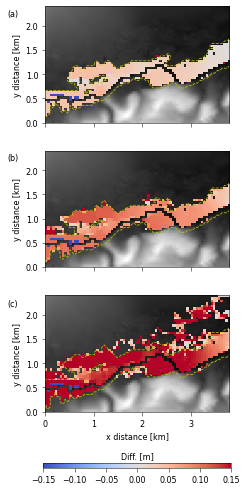

In [61]:
# Map difference
Sdiff = z_map - S_map
fig, ax = plt.subplots( figsize=(8.5/2.54,18/2.54), nrows=3, sharex=True, sharey=True )

for i in range(Sdiff.shape[-1]):

    masked_data = np.ma.masked_where( Sdiff[:,:,i] == 0, Sdiff[:,:,i] )
    masked_data = np.ma.masked_where( channel[bounds[0]:bounds[1],bounds[2]:bounds[3]] >= 0, masked_data )
    dem_img = ax[i].imshow( dem[bounds[0]:bounds[1],bounds[2]:bounds[3]], cmap=cm.gray,
                        extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05])

    cmap = cm.Blues  # Can be any colormap that you want after the cm
    divnorm = colors.TwoSlopeNorm(vcenter=0., vmin=-0.15, vmax=0.15)
    image = ax[i].imshow( masked_data[:,:], cmap='coolwarm', norm=divnorm,
                    interpolation='none', extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05] )


    ax[i].contour( S_map[::-1,:,i], levels=[-0.001, 0.0001], colors='y', linestyles='--',
                extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05], linewidth=2 )
    
    ax[i].set_ylabel( 'y distance [km]' )
    
# Colorbar
cax = fig.add_axes([0.17, 0.03, 0.78, 0.01]) # [left, bottom, width, height]
cbar = plt.colorbar( image, cax=cax, orientation='horizontal')
# divider = make_axes_locatable(ax[-1])
# cax = divider.append_axes( "bottom", size="3%", pad=0.1 )
# cbar = fig.colorbar( image, cax=cax, orientation='horizontal' )
cbar.ax.set_xlabel('Diff. [m]', rotation=0, loc='center' )
cbar.ax.xaxis.set_label_position('top') 
for tick in cbar.ax.get_xticklabels():
    tick.set_rotation(0)

# X axis labels
ax[-1].set_xlabel( 'x distance [km]' )

# Letter labels
ax[0].text(0.02, 0.915, '(a)', fontsize=8, transform=plt.gcf().transFigure)
ax[1].text(0.02, 0.632, '(b)', fontsize=8, transform=plt.gcf().transFigure)
ax[2].text(0.02, 0.347, '(c)', fontsize=8, transform=plt.gcf().transFigure)

fig.tight_layout()
fig.subplots_adjust( bottom=0.14 )

Plot for paper

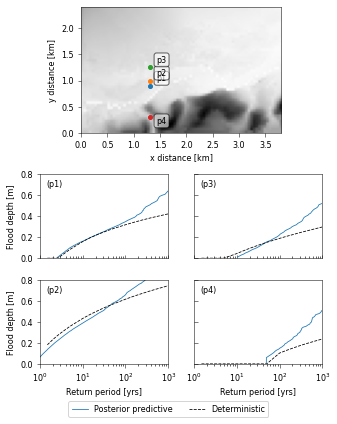

In [68]:
fig = plt.figure( figsize=(12/2.54,15/2.54) )
spec = fig.add_gridspec(2,1, height_ratios=(1,1.5))

gs_lower = spec[1].subgridspec(2,2)

ax0 = fig.add_subplot( spec[0] ) # span two columns
ax10 = fig.add_subplot( gs_lower[0,0] )
ax20 = fig.add_subplot( gs_lower[1,0], sharex=ax10 )
ax11 = fig.add_subplot( gs_lower[0,1], sharey=ax10 )
ax21 = fig.add_subplot( gs_lower[1,1], sharex=ax11, sharey=ax20 )

# Map plot
o1 = ax0.imshow( dem, cmap='Greys', extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05] )
# o2 = ax0.imshow( z, cmap='Blues', extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05],
#                 vmin=0.9, vmax=1.1, alpha=0.6 )
o3 = ax0.imshow( channel, cmap='Blues', extent=[0,z.shape[1]*0.05,0,z.shape[0]*0.05],
                vmin=0.99, vmax=1.0 )
ax0.set_xlabel( 'x distance [km]' )
ax0.set_ylabel( 'y distance [km]' )

# bounds = [9,45,0,68]
# 0.05*col2, 0.05*(36-row2)
# Hazard curves
pxi, pyi = 21+9, 26
row, col = (bounds[2]+py)*0.05, (dem.shape[0]-bounds[0]-pxi)*0.05
ax0.plot( row, col, marker='o', markersize=4, color='C0', label='(a)' )
ax0.annotate( 'p1', xy=(row, col), xytext=(7, 5), textcoords="offset pixels",
              bbox=dict(boxstyle="round,pad=0.3", fc='w', ec='k', alpha=.6) )
rs_sort, Femp = ecdf( S_sim[:,pxi,pyi] )
lZi_1 = N0/T0 * np.interp( z_plot, rs_sort, 1-Femp )
ax10.plot( 1/lZi_1, z_plot, label='All' )
ax10.plot( trs, S_map_trs[:,pxi,pyi], label='None', linestyle='--', color='k' )
# ax10.set_xlabel( 'Return period [yr]' )
plt.setp(ax10.get_xticklabels(), visible=False)
ax10.tick_params( axis="x", which='both', direction="in" )
ax10.set_ylabel( 'Flood depth [m]' )
ax10.set_xlim([1,1000])
ax10.set_ylim([0,0.8])
ax10.set_xscale('log')
ax10.text( 0.05, 0.85, '(p1)', transform=ax10.transAxes, fontsize=8 )

pxi, pyi = 19+9, 46
row, col = (bounds[2]+py)*0.05, (dem.shape[0]-bounds[0]-pxi)*0.05
ax0.plot( row, col, marker='o', markersize=4, color='C1', label='(b)' )
ax0.annotate( 'p2', xy=(row, col), xytext=(7, 5), textcoords="offset pixels",
              bbox=dict(boxstyle="round,pad=0.3", fc='w', ec='k', alpha=.6) )
rs_sort, Femp = ecdf( S_sim[:,pxi,pyi] )
lZi_1 = N0/T0 * np.interp( z_plot, rs_sort, 1-Femp )
ax20.plot( 1/lZi_1, z_plot, label='All' )
ax20.plot( trs, S_map_trs[:,pxi,pyi], label='None', linestyle='--', color='k' )
ax20.set_xlabel( 'Return period [yrs]' )
ax20.set_ylabel( 'Flood depth [m]' )
ax20.set_xlim([1,1000])
ax20.set_ylim([0,0.8])
ax20.set_xscale('log')
ax20.text( 0.05, 0.85, '(p2)', transform=ax20.transAxes, fontsize=8 )

pxi, pyi = 14+9, 56
row, col = (bounds[2]+py)*0.05, (dem.shape[0]-bounds[0]-pxi)*0.05
ax0.plot( row, col, marker='o', markersize=4, color='C2', label='(c)' )
ax0.annotate( 'p3', xy=(row, col), xytext=(7, 5), textcoords="offset pixels",
              bbox=dict(boxstyle="round,pad=0.3", fc='w', ec='k', alpha=.6) )
rs_sort, Femp = ecdf( S_sim[:,pxi,pyi] )
lZi_1 = N0/T0 * np.interp( z_plot, rs_sort, 1-Femp )
ax11.plot( 1/lZi_1, z_plot, label='All' )
ax11.plot( trs, S_map_trs[:,pxi,pyi], label='None', linestyle='--', color='k' )
# ax11.set_xlabel( 'Return period [yr]' )
plt.setp(ax11.get_xticklabels(), visible=False)
# ax11.set_ylabel( 'Flood depth [m]' )
plt.setp(ax11.get_yticklabels(), visible=False)
ax11.tick_params( axis="both", which='both', direction="in" )
ax11.set_xlim([1,1000])
ax11.set_ylim([0,0.8])
ax11.set_xscale('log')
ax11.text( 0.05, 0.85, '(p3)', transform=ax11.transAxes, fontsize=8 )

pxi, pyi = 33+9, 7
row, col = (bounds[2]+py)*0.05, (dem.shape[0]-bounds[0]-pxi)*0.05
ax0.plot( row, col, marker='o', markersize=4, color='C3', label='(d)' )
ax0.annotate( 'p4', xy=(row, col), xytext=(7, -6), textcoords="offset pixels",
              bbox=dict(boxstyle="round,pad=0.3", fc='w', ec='k', alpha=.6) )
rs_sort, Femp = ecdf( S_sim[:,pxi,pyi] )
lZi_1 = N0/T0 * np.interp( z_plot, rs_sort, 1-Femp )
ax21.plot( 1/lZi_1, z_plot, label='Posterior predictive' )
ax21.plot( trs, S_map_trs[:,pxi,pyi], label='Deterministic', linestyle='--', color='k' )
ax21.set_xlabel( 'Return period [yrs]' )
# ax21.set_ylabel( 'Flood depth [m]' )
plt.setp(ax21.get_yticklabels(), visible=False)
ax21.tick_params( axis="y", which='both', direction="in" )
ax21.set_xlim([1,1000])
ax21.set_ylim([0,0.8])
ax21.set_xscale('log')
ax21.text( 0.05, 0.85, '(p4)', transform=ax21.transAxes, fontsize=8 )
ax21.legend( ncol=2, loc='upper center', bbox_to_anchor=(-0.2,-0.4) )

fig.tight_layout()
fig.subplots_adjust( bottom=0.14 )

### 3.4 Hazard curves uncertainty

Compute hazard curves for each posterior sample of the model's parameters (both the GPD parameters and the roughness parameters)

The hazard are obtained from simulations 100 simulations of all parameters. For each simulation, the inundation map was computed for 11 different return period (1,2,5,10,25,50,100,250,500,750,1000). This results in 11 x 100 = 1,100 simulations that were performed in a separate script (hazard_curves.py) and saved in a pickle file.

In [80]:
# Load simulations for curves
sim_name = 'data\\180423_100epis_GLUE'
with open( sim_name+'.pkl', 'rb') as file:
    parameters0 = pickle.load( file )
    S0_sim = pickle.load( file )
    S0_sim_1 = pickle.load( file )
    S0_sim_2 = pickle.load( file )
    S0_sim_3 = pickle.load( file )

# Return periods used in the simulation
Trs = parameters0['Trs']

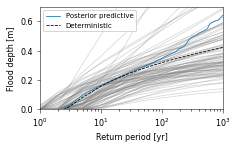

In [67]:
# Exceedance curves
fig, ax = plt.subplots( figsize=(8.5/2.54,5.5/2.54) )

# Posterior hazard curves
ax.plot( Trs, S0_sim[:,:,px,py].T, color='gray', alpha=.3 )

# Posterior predictive estimate
ax.plot( 1/lZ_1, z_plot, label='Posterior predictive' )

# Best-fit curve
ax.plot( trs, S_map_trs[:,px,py], label='Deterministic', linestyle='--', color='k' )

ax.set_xlabel( 'Return period [yr]' )
ax.set_ylabel( 'Flood depth [m]' )
ax.set_xlim([1,1000])
ax.set_ylim([0,0.7])
ax.set_xscale('log')
ax.legend( loc='upper left', fontsize=7 )
fig.tight_layout()